In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import cm
from datetime import datetime

from datetime import datetime
from pyproj import Transformer
from scipy.ndimage import convolve
%run -i ncbx_funcs.py

In [2]:
# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purple5 = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']
ored3 = ['#fee8c8','#fdbb84','#e34a33']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cm.terrain # This matches COFDL talk
# tcmap=cmap_ncb # This matches JGR
tcmap.set_bad(color='darkgray')

# tcmapw=cmap_ncb
# tcmapw.set_bad(color='white')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')

# This is the difference color map
# dcmapw = cm.seismic.copy()
# dcmapw.set_bad(color='white')

ygbmap = cm.YlGnBu_r.copy()
ygbmap.set_bad(color='darkgray')

prmap = cm.PuRd.copy()
prmap.set_bad(color='darkgray')

#### Note from John Warner: how he did his volume calcs in Matlab
here is what i did to get those dorian volume calcs  
  
%first run this to get h_init  
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/Dorian_NCB_his_00001.nc';    %get h  
  
tidx=1; h=ncread(url,'bath',[1 1 tidx],[Inf Inf 1]);  
pm=ncread(url,'pm');  
pn=ncread(url,'pn');  
  
% now use these 4 urls  
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/Dorian_NCB_his_00019.nc';  %CSYV
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/Dorian_NCB_his_00019.nc';  %CSNV
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/Dorian_NCB_his_00019.nc';  %FSYV
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/Dorian_NCB_his_00019.nc';  %FSNV
%  
%  for each of the 4 urls above, i ran this code:  
  
tidx=4; bath_end=ncread(url,'bath',[1 1 tidx],[Inf Inf 1]);  
  
%conservative estimate Left:  
istr=830; iend=900;  
jstr=180; jend=430;  
zz=(bath_end(istr:iend,jstr:jend)-h(istr:iend,jstr:jend))./pm(istr:iend,jstr:jend)./pn(istr:iend,jstr:jend);  
sed_loss=sum(sum(zz))  
%69573 m3 right /(950-800) = 70 *1.5m = 105 =   662 m3/m  
  
%conservative estimate RIGHT:  
istr=380; iend=480;  
jstr=180; jend=430;  
zz=(bath_end(istr:iend,jstr:jend)-h(istr:iend,jstr:jend))./pm(istr:iend,jstr:jend)./pn(istr:iend,jstr:jend);  
sed_loss=sum(sum(zz))  
%62175 m3  left/(480-380) = 100 *1.5m = 150 =   414 m3/m  
  
  
sim  left(tot , m3/m)   right(tot , m3/m)  
45    62,175   414       69,573     662  
44    75,755   505       87,293     831  
50    77,335   515       97,836     434  
51    96,030   640       151,720    674  

In [21]:
# load inital bathy
url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/Dorian_NCB_his_00001.nc'
ds_init = xr.open_dataset(url)
bathi = -ds_init.bath[0,:,:].load().values
pm = ds_init.pm[:,:].load().values
pn = ds_init.pn[:,:].load().values
init_time = ds_init.ocean_time[0].load().values
print('Initial time: ',init_time)

# load final bathy for four cases
tidx = -1 # last file
url_CSYV='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/Dorian_NCB_his_00019.nc'
ds_CSYV = xr.open_dataset(url_CSYV)
bathf_CSYV = -ds_CSYV.bath[tidx,:,:].load().values
final_time = ds_CSYV.ocean_time[tidx].load().values
print('Final time: ',final_time)

url_CSNV='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/Dorian_NCB_his_00019.nc'
ds_CSNV = xr.open_dataset(url_CSNV)
bathf_CSNV = -ds_CSNV.bath[tidx,:,:].load().values

url_FSYV='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/Dorian_NCB_his_00019.nc'
ds_FSYV = xr.open_dataset(url_FSYV)
bathf_FSYV = -ds_FSYV.bath[tidx,:,:].load().values

url_FSNV='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/Dorian_NCB_his_00019.nc'
ds_FSNV = xr.open_dataset(url_FSNV)
bathf_FSNV = -ds_FSNV.bath[tidx,:,:].load().values

Initial time:  2019-09-06T00:00:00.000000000
Final time:  2019-09-06T19:00:00.060924928


Left CSYV: -61886, -413
Left CSNV: -75328, -502
Left FSYV: -76906, -513
Left FSNV: -95346, -636
Right CSYV: -69307, -660
Right CSNV: -86821, -827
Right FSYV: -78371, -746
Right FSNV: -112309, -1070


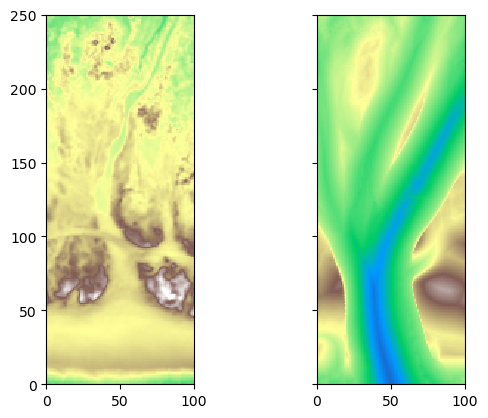

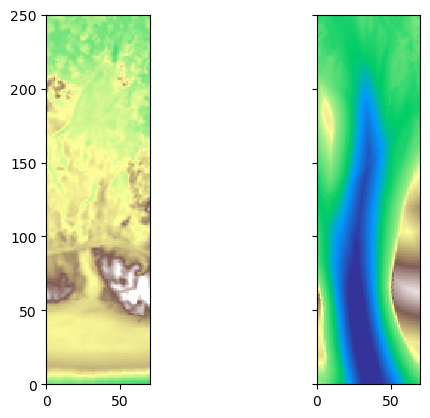

In [40]:
# conservative estimate left (John's right):
istr=380
iend=480
jstr=180
jend=430
i = -1 # offset for converting Matlab indexing to Python indexing. Should be -1, but experimenting

# note indices are reversed in Python, and index from zero
zi = bathi[jstr+i:jend+i,istr+i:iend+i]
zf_CSYV = bathf_CSYV[jstr+i:jend+i,istr+i:iend+i]
Lsed_loss_CSYV = (zf_CSYV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Left CSYV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_CSYV), np.sum(Lsed_loss_CSYV)/((iend-istr)*1.5) ) )

zf_CSNV = bathf_CSNV[jstr+i:jend+i,istr+i:iend+i]
Lsed_loss_CSNV = (zf_CSNV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Left CSNV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_CSNV), np.sum(Lsed_loss_CSNV)/((iend-istr)*1.5) ) )

zf_FSYV = bathf_FSYV[jstr+i:jend+i,istr+i:iend+i]
Lsed_loss_FSYV = (zf_FSYV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Left FSYV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_FSYV), np.sum(Lsed_loss_FSYV)/((iend-istr)*1.5) ) )

zf_FSNV = bathf_FSNV[jstr+i:jend+i,istr+i:iend+i]
Lsed_loss_FSNV = (zf_FSNV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Left FSNV: {:.0f}, {:.0f}'.format( np.sum(Lsed_loss_FSNV), np.sum(Lsed_loss_FSNV)/((iend-istr)*1.5) ) )

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].pcolormesh( zi, cmap=tcmap, vmin = -2., vmax = 5 )
axs[0].set_aspect('equal', adjustable='box')
axs[1].pcolormesh( zf_CSYV, cmap=tcmap, vmin = -2., vmax = 5 )
axs[1].set_aspect('equal', adjustable='box')

# conservative estimate right (John's left):
istr=830
iend=900
jstr=180
jend=430
i = -1 # offset for converting Matlab indexing to Python indexing. Should be -1, but experimenting

# note indices are reversed in Python, and index from zero
zi = bathi[jstr+i:jend+i,istr+i:iend+i]
zf_CSYV = bathf_CSYV[jstr+i:jend+i,istr+i:iend+i]
Rsed_loss_CSYV = (zf_CSYV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Right CSYV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_CSYV), np.sum(Rsed_loss_CSYV)/((iend-istr)*1.5) ) )

zf_CSNV = bathf_CSNV[jstr+i:jend+i,istr+i:iend+i]
Rsed_loss_CSNV = (zf_CSNV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Right CSNV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_CSNV), np.sum(Rsed_loss_CSNV)/((iend-istr)*1.5) ) )

zf_FSYV = bathf_FSYV[jstr+i:jend+i,istr+i:iend+i]
Rsed_loss_FSYV = (zf_FSYV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Right FSYV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_FSYV), np.sum(Rsed_loss_FSYV)/((iend-istr)*1.5) ) )

zf_FSNV = bathf_FSNV[jstr+i:jend+i,istr+i:iend+i]
Rsed_loss_FSNV = (zf_FSNV - zi) / pm[jstr+i:jend+i,istr+i:iend+i] / pn[jstr+i:jend+i,istr+i:iend+i]
print('Right FSNV: {:.0f}, {:.0f}'.format( np.sum(Rsed_loss_FSNV), np.sum(Rsed_loss_FSNV)/((iend-istr)*1.5) ) )

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].pcolormesh( zi, cmap=tcmap, vmin = -2., vmax = 5 )
axs[0].set_aspect('equal', adjustable='box')
axs[1].pcolormesh( zf_CSYV, cmap=tcmap, vmin = -2., vmax = 5 )
axs[1].set_aspect('equal', adjustable='box')

# sim left(tot , m3/m) right(tot , m3/m)
# 45 62,175 414 69,573 662
# 44 75,755 505 87,293 831
# 50 77,335 515 97,836 434
# 51 96,030 640 151,720 674

In [36]:
# load the pre- post- observations
# This does not have the same shape as John's model files.
url = '/vortexfs1/home/csherwood/proj/dorian/NCoreBanks_sub9_pre_post_veg.nc'
ds_obs = xr.open_dataset(url)
ds_obs

<xarray.Dataset>
Dimensions:           (one: 1, bath: 1, eta_rho: 1017, xi_rho: 1317,
                       eta_psi: 1016, xi_psi: 1316, eta_u: 1017, xi_u: 1316,
                       eta_v: 1016, xi_v: 1317)
Dimensions without coordinates: one, bath, eta_rho, xi_rho, eta_psi, xi_psi,
                                eta_u, xi_u, eta_v, xi_v
Data variables: (12/37)
    xl                (one) float64 ...
    el                (one) float64 ...
    JPRJ              |S2 ...
    spherical         (one) |S1 ...
    depthmin          (one) int16 ...
    depthmax          (one) int16 ...
    ...                ...
    mask_v            (eta_v, xi_v) float64 ...
    mask_psi          (eta_psi, xi_psi) float64 ...
    angle             (eta_rho, xi_rho) float64 ...
    canopy_height     (eta_rho, xi_rho) float64 ...
    pre_Dorian_elev   (eta_rho, xi_rho) float64 ...
    post_Dorian_elev  (eta_rho, xi_rho) float64 ...
Attributes:
    type:     ROMS GRID file
    gridid:   theGridTitle
    history:  Created by create_roms_netcdf_grid_file, on 02-Sep-2021 12:34:2...
    title:    ROMS Application

In [38]:
ds_CSYV

<xarray.Dataset>
Dimensions:                 (tracer: 4, NST: 3, s_rho: 8, s_w: 9,
                             eta_rho: 1057, xi_rho: 1317, eta_u: 1057,
                             xi_u: 1316, eta_v: 1056, xi_v: 1317,
                             eta_psi: 1056, xi_psi: 1316, ocean_time: 4,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 -0.9375 -0.8125 ... -0.1875 -0.0625
  * s_w                     (s_w) float64 -1.0 -0.875 -0.75 ... -0.25 -0.125 0.0
    lon_rho                 (eta_rho, xi_rho) float64 -76.13 -76.13 ... -76.19
    lat_rho                 (eta_rho, xi_rho) float64 34.94 34.94 ... 35.02
    lon_u                   (eta_u, xi_u) float64 ...
    lat_u                   (eta_u, xi_u) float64 ...
    lon_v                   (eta_v, xi_v) float64 ...
    lat_v                   (eta_v, xi_v) float64 ...
    lon_psi                 (eta_psi, xi_psi) float64 ...
    lat_psi                 (eta_psi, xi_psi) float64 ...
  * ocean_time              (ocean_time) datetime64[ns] 2019-09-06T18:15:00.0...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/182)
    ntimes                  int32 ...
    ndtfast                 int32 ...
    dt                      float64 ...
    dtfast                  float64 ...
    dstart                  datetime64[ns] ...
    nHIS                    int32 ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/34)
    file:                            ./Output/Dorian_NCB_his_00019.nc
    format:                          netCDF-3 64bit offset file
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           Hurricane Dorian North Core Banks
    var_info:                        varinfo.dat
    ...                              ...
    history:                         ROMS/TOMS, Version 3.9, Saturday - Octob...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_B...
    DODS_EXTRA.Unlimited_Dimension:  ocean_time
    EXTRA_DIMENSION.N:               8
    EXTRA_DIMENSION.boundary:        4

In [37]:
h_pre_obs = ds_obs.pre_Dorian_elev[:,:]
h_pst_obs = ds_obs.post_Dorian_elev[:,:]

x = ds_obs.xi_rho
y = ds_obs.eta_rho

In [23]:
# load lat/lon, convert to island coordinates
lon = np.squeeze( ds_CSYV.lon_rho.load().values )
lat = np.squeeze( ds_CSYV.lat_rho.load().values )

# convert lat/lon to UTM zone 18N, and then to island coordinates
transformer = Transformer.from_crs( 'epsg:4326', 'epsg:26918',  ) # WGS84 to UTM18
utmx, utmy = transformer.transform( lat, lon )
xisl, yisl = UTM2Island(utmx, utmy, eoff=383520.0, noff=3860830.0, rot=42.0)
print('Shape of xisl, yisl: ', xisl.shape, yisl.shape)

Shape of xisl, yisl:  (1057, 1317) (1057, 1317)


In [26]:
# smooth bathy for making contour maps
# experimenting with size of kernal suggest 15 is ok
ik = 15
k = np.ones((ik, ik)) / (ik*ik)
bathis = convolve(bathi,k,mode='nearest')
bathfs_CSYV = convolve(bathf_CSYV,k,mode='nearest')

# Use a central line for cross-shore distance
y = np.squeeze( yisl[:,550] )

# find the average shoreline location
mbathi = np.mean(bathi[:,100:1200], axis=1)
mbathf_CSYV = np.mean(bathf_CSYV[:,100:1200], axis=1)

ishorey = np.argwhere(mbathi>=0.)[0]
print('Index of shoreline and y-location from final CSYV run, used in four_run_plots:')
print('[168], [329.28]')
print('Index of shoreline and y-location:')
print(ishorey, y[ishorey])

# use this for the cross-shore location by adding the offset
offset = y[ishorey]
y = y-offset
yisl = yisl-offset
xisl = xisl-np.min(xisl[ishorey])
# make the alongshore coordinates
x = np.squeeze( xisl[ishorey] - np.min(xisl[ishorey]) )

# area calculations
pm = ds_CSYV.pm[:,:].load().values
pn = ds_CSYV.pn[:,:].load().values
area = 1./pm * 1./pn
print('Shape of area: ', area.shape)

Index of shoreline and y-location from final CSYV run, used in four_run_plots:
[168], [329.28]
Index of shoreline and y-location:
[172] [0.]
Shape of area:  (1057, 1317)


In [25]:
# Convert lat/lon to UTM zone 18N, and then to island coordinates
# load lat/lon, convert to island coordinates
lon_obs = np.squeeze( ds_obs.lon_rho.load().values )
lat_obs = np.squeeze( ds_obs.lat_rho.load().values )
utmx, utmy = transformer.transform( lat_obs, lon_obs )
xisl_obs, yisl_obs = UTM2Island(utmx, utmy, eoff=383520.0, noff=3860830.0, rot=42.0)
print('Shape of xisl_obs, yisl_obs: ', xisl_obs.shape, yisl_obs.shape)

NameError: name 'ds_obs' is not defined

In [9]:
# not sure this will work
yisl_obs = yisl_obs-offset
xisl_obs = xisl_obs-np.min(xisl_obs[ishorey])

In [10]:
# h_pre_mod = -ds_grid.h
h_pre_mod = bathi
h_pst_mod = bathf_CSYV

h_pre_obs = ds_obs.pre_Dorian_elev[:,:]
h_pst_obs = ds_obs.post_Dorian_elev[:,:]

/tmp/ipykernel_76980/1627418895.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  map00 = ax[0,0].pcolormesh(xisl_obs,yisl_obs,h_pre_obs, cmap=tcmap, vmin = -2., vmax = 5)
/tmp/ipykernel_76980/1627418895.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  map10 = ax[1,0].pcolormesh(xisl_obs,yisl_obs,h_pst_obs, cmap=tcmap, vmin = -2., vmax = 5)
/tmp/ipykernel_76980/1627418895.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case,

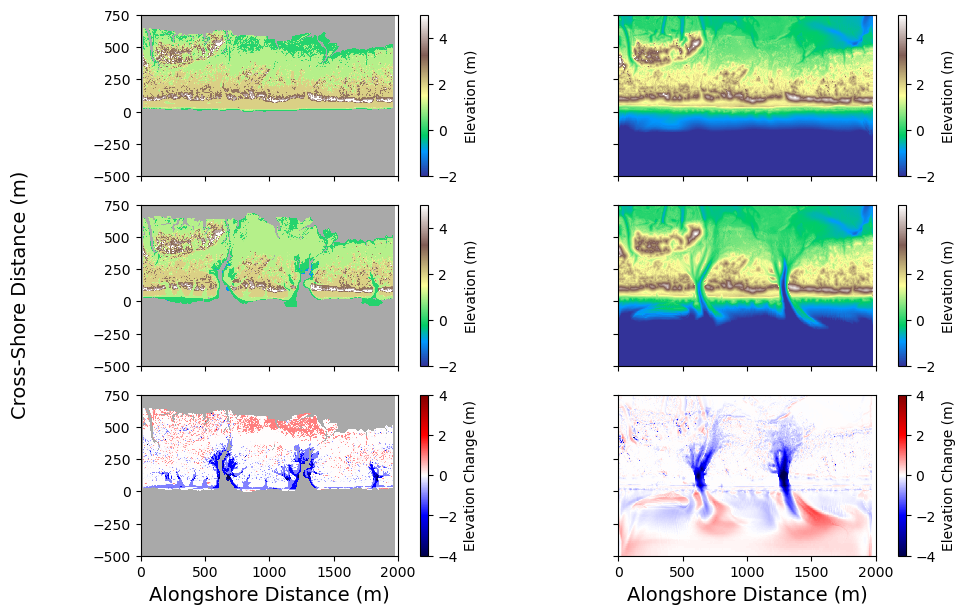

In [11]:

xs = 0
xe = 2000
ys = -500
ye = 750

fig, ax = plt.subplots(3,2, figsize=(10,6),sharex=True,sharey=True)
fig.tight_layout()
map00 = ax[0,0].pcolormesh(xisl_obs,yisl_obs,h_pre_obs, cmap=tcmap, vmin = -2., vmax = 5)
# ax[0,0].set_ylim([0,600])
# ax[0,0].set_xlim([0,1250])
ax[0,0].set_aspect('equal')

fig.colorbar(map00, ax=ax[0,0], label='Elevation (m)')
#ax[0,0].set_xticklabels([])

map10 = ax[1,0].pcolormesh(xisl_obs,yisl_obs,h_pst_obs, cmap=tcmap, vmin = -2., vmax = 5)
ax[1,0].set_ylim([ys, ye])
ax[1,0].set_xlim([xs, xe])
ax[1,0].set_aspect('equal')

fig.colorbar(map10, ax=ax[1,0], label='Elevation (m)')
#ax[1,0].set_xticklabels([])

map20 = ax[2,0].pcolormesh(xisl_obs,yisl_obs,(h_pst_obs-h_pre_obs), cmap=dcmap, vmin=-4, vmax=4 )
ax[2,0].set_ylim([ys, ye])
ax[2,0].set_xlim([xs, xe])
ax[2,0].set_aspect('equal')

fig.colorbar(map20, ax=ax[2,0], label='Elevation Change (m)')

map01 = ax[0,1].pcolormesh(xisl,yisl,bathi, cmap=tcmap, vmin = -2., vmax = 5)
ax[0,1].set_ylim([ys, ye])
ax[0,1].set_xlim([xs, xe])
ax[0,1].set_aspect('equal')

fig.colorbar(map01, ax=ax[0,1], label='Elevation (m)')
#ax[0,1].set_xticklabels([])

map11 = ax[1,1].pcolormesh(xisl,yisl,bathf_CSYV, cmap=tcmap, vmin = -2., vmax = 5)
ax[1,1].set_ylim([ys, ye])
ax[1,1].set_xlim([xs, xe])
ax[1,1].set_aspect('equal')

fig.colorbar(map11, ax=ax[1,1], label='Elevation (m)')
#ax[1,1].set_xticklabels([])

map21 = ax[2,1].pcolormesh(xisl,yisl,bdiff_CSYV, cmap=dcmap, vmin=-4, vmax=4 )
ax[2,1].set_ylim([ys, ye])
ax[2,1].set_xlim([xs, xe])
ax[2,1].set_aspect('equal')

_ = fig.colorbar(map20, ax=ax[2,1], label='Elevation Change (m)')

fig.text(0.02, 0.5, 'Cross-Shore Distance (m)', fontsize=14, va='center', rotation='vertical')
ax[2,0].set_xlabel('Alongshore Distance (m)', fontsize=14)
ax[2,1].set_xlabel('Alongshore Distance (m)', fontsize=14)

# axins0 = inset_axes(axs[2,0],
#                     width="95%",  
#                     height="5%",
#                     loc='lower center',
#                     borderpad=-5
#                    )
# cb0 = fig.colorbar(m1, cax=axins0, orientation="horizontal")
# cb0.set_label(label='Elevation (m)', size=14)

# axins1 = inset_axes(axs[2,1],
#                     width="95%",  
#                     height="5%",
#                     loc='lower center',
#                     borderpad=-5

plt.savefig('CSYV_mod_obs_pre_post_diff.png',dpi=200, bbox_inches='tight')